In [6]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import copy

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model import Symmetric, DeepSets, KNN, KK
from sample import generate_data, generate_narrow_data
from train import train
from evaluate import generalization_error, cross_validate

%matplotlib inline

In [21]:
def compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, objective, narrow, verbose = True, log_plot = False, scaleup = False):
    print("currently", objective.__name__)

    c = 1 if not scaleup else 2
    print(c)

    f1 = Symmetric(input_dim, c * hidden_dim, hidden_dim)
    f2 = KNN(input_dim, c * hidden_dim, hidden_dim)
    f3 = KK(input_dim, c * hidden_dim, hidden_dim)

    f1.__name__ = "S1"
    f2.__name__ = "S2"
    f3.__name__ = "S3"

    models = [f1, f2, f3]
    
    lambs = [0., 1e-6, 1e-4, 1e-2]
    N_list = np.arange(2, N_max + 16)

    for model in models:
        x, y = generate_data(N_max, batch_size, input_dim, objective, narrow)
        cv_models = cross_validate(model, x, y, iterations, lambs, verbose)
        
        validation_errors = np.zeros_like(lambs)
        for i, cv_model in enumerate(cv_models):
            validation_errors[i] = generalization_error([N_max], 1000, cv_model, objective, narrow)[0]
        
        i = np.argmin(validation_errors)
        lamb = lambs[i]
            
        runs = 10
        run_errors = np.zeros((runs, len(N_list)))
        for i in range(runs):
            x, y = generate_data(N_max, batch_size, input_dim, objective, narrow)
            model_copy = copy.deepcopy(model)
            model_copy.reinit()
            train(model_copy, x, y, iterations, lamb)
            errors = generalization_error(N_list, 1000, model_copy, objective, narrow)
            run_errors[i] = np.array(errors)
        
        mean_error = np.mean(run_errors, axis = 0)
        std_error = np.std(run_errors, axis = 0)
        if verbose:
            print("performance of ", model.__name__, " on ", objective.__name__)
            print("lamb =", lamb)
            print(mean_error)
            print(std_error)
            
            
        narrow_str = "Narrow" if narrow else "Wide"
        scaleup_str = "scaleup" if scaleup else ""
        save_str = model.__name__ + "_" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scaleup_str
            
        np.save(save_str + "_mean", mean_error)
        np.save(save_str + "_std", std_error)
        
        if log_plot:
            plt.semilogy(N_list, mean_error, label = model.__name__)
        else:
            plt.plot(N_list, mean_error, label = model.__name__)
        plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)

    
    plt.legend()
    plt.ylim([1e-5, 1e-1]) 

    plt.xlabel("N")
    plt.ylabel("Mean Square Error")
    narrow_str = "Narrow" if narrow else "Wide"
    plt.title(narrow_str + " generalization for " + objective.__name__)
    scaleup_str = "scaleup" if scaleup else ""
#     plt.savefig("plots_high_dim/" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scaleup_str)
    plt.show()
    plt.close()

In [7]:
#For the rest of the notebook
input_dim = 10

In [8]:
mean = lambda x: np.mean(norm(x, axis = 2), axis = 1, keepdims = True)

median = lambda x: np.median(norm(x, axis = 2), axis = 1, keepdims = True)

maximum = lambda x: np.max(norm(x, axis = 2), axis = 1, keepdims = True)

lamb = 0.1
softmax = lambda x: lamb * np.log(np.mean(np.exp(norm(x, axis = 2) / lamb), axis = 1, keepdims = True))

second = lambda x: np.sort(norm(x, axis = 2), axis = 1)[:,-2].reshape(-1,1)

In [10]:
### May need to sample several neurons to find one that isn't degenerate on the domain


teacher = Symmetric(input_dim, 10, 1)
torch.nn.init.uniform_(teacher.phi.fc.weight, a = -0.2, b = 1.0)
teacher.eval()

def neuron(x):
    x = torch.from_numpy(x).float()
    y = teacher(x)
    return y.data.numpy().reshape(-1, 1)

x, y = generate_narrow_data(3, 15, input_dim, neuron)
print(y.data.numpy().flatten())

[-0.4159332   0.         -0.20586732  0.         -0.21240376 -0.25716677
 -0.2178469   0.         -0.17198043 -0.49157095 -0.17289805 -0.25022185
 -0.06915313 -0.1160903  -0.23129481]


In [14]:
### May need to sample several neurons to find one that isn't degenerate on the domain

smooth_teacher = Symmetric(input_dim, 20, 1)
torch.nn.init.uniform_(teacher.rho.fc1.weight,a = -0.2, b = 1.0)
smooth_teacher.eval()

def smooth_neuron(x):
    x = torch.from_numpy(x).float()
    y = smooth_teacher(x)
    return y.data.numpy().reshape(-1, 1)

x, y = generate_narrow_data(3, 10, input_dim, smooth_neuron)
print(y.data.numpy().flatten())

[-0.03791815  0.         -0.03413719 -0.04336375 -0.03677244 -0.08120133
 -0.04764245  0.         -0.02808477  0.        ]


In [15]:
neuron.__name__ = "neuron"
smooth_neuron.__name__ = "smooth_neuron"
maximum.__name__ = "maximum"
softmax.__name__ = "softmax"
median.__name__ = "median"
mean.__name__ = "mean"
second.__name__ = "second"

In [16]:
###############################################

In [24]:
#Run to generate plots in Figure 1:

N_max = 4
hidden_dim = 100

iterations = 5000
batch_size = 100

currently neuron
1
check for overfitting power of S1
[1.2964870929718018, 0.0013136945199221373, 3.7343778558351914e-07, 2.7985472570435377e-06, 0.006056393496692181, 4.844321210839553e-08, 9.397038269048918e-13, 2.979319846385664e-10, 0.0001882985234260559, 0.0002121023426298052]
2.0534684792416352e-13
performance of  S1  on  neuron
lamb = 0.0001
[0.11596007 0.0772782  0.05791335 0.0476715  0.04041408 0.03510185
 0.03092461 0.02824945 0.02512068 0.02350102 0.02288468 0.02059966
 0.01986709 0.01826139 0.01788848 0.01676694 0.01619144 0.01539636]
[0.01031497 0.00789146 0.00449582 0.00365073 0.00360385 0.00312275
 0.00272541 0.00236459 0.00148488 0.00204587 0.00213257 0.00188389
 0.0012263  0.00183674 0.00190611 0.00191601 0.00201258 0.00154619]
check for overfitting power of S2
[1.2052656412124634, 0.006246887147426605, 0.00042937113903462887, 7.961475785123184e-05, 9.862056685960852e-06, 0.0009613479487597942, 0.00016072942526079714, 0.00023561301350127906, 3.4022409067802073e-07, 0.00

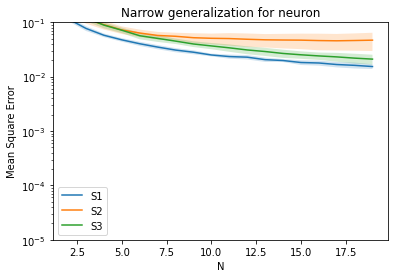

In [25]:
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True)

currently smooth_neuron
1
check for overfitting power of S1
[0.006475509610027075, 4.434388145568846e-08, 9.664721289937006e-08, 1.5056139091029763e-06, 2.1575829123321455e-07, 4.557130068860715e-06, 5.067016251025791e-11, 1.6796848285594024e-05, 3.6979930229108504e-09, 2.0928315504209483e-12]
9.783124831075352e-14
performance of  S1  on  smooth_neuron
lamb = 1e-06
[4.15341006e-04 2.99416798e-04 2.36993721e-04 1.93346018e-04
 1.67953668e-04 1.44524800e-04 1.31902566e-04 1.18700162e-04
 1.11500396e-04 9.99301294e-05 9.59502540e-05 9.04808709e-05
 8.49197691e-05 8.20729903e-05 7.89411286e-05 7.43042106e-05
 7.39587427e-05 6.86621126e-05]
[4.45474921e-05 3.32817643e-05 2.13561271e-05 2.68891441e-05
 1.71627182e-05 1.73914849e-05 1.44722595e-05 1.26916430e-05
 1.16870975e-05 1.26993355e-05 1.28453294e-05 1.26657404e-05
 1.28299376e-05 1.08574332e-05 1.04341600e-05 1.27243494e-05
 1.10560479e-05 1.09193919e-05]
check for overfitting power of S2
[0.0020454456098377705, 2.3482064079871634e-06

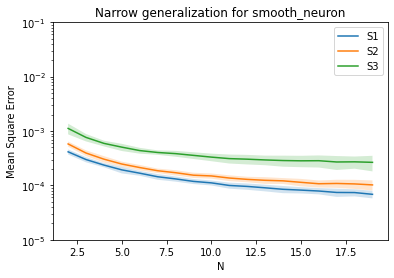

In [26]:
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True)

In [ ]:
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, mean, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , mean, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, median, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , median, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, maximum, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , maximum, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, softmax, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , softmax, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, second, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , second, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, neuron, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, smooth_neuron, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True)

In [ ]:
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True, scaleup = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True, scaleup = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True, scaleup = False)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True, scaleup = False)

In [ ]:
###############################################